In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import igraph as ig
import torch
import plotly.express as px
import matplotlib.pyplot as plt
from src import Simulation as sim
from src import Dir_Reg
from src import Dir_Reg_copy as DR
from src import Dirichlet_Parameter as DP
from src import Align
from src import visualize_latent_space as vls
from src import ABC_Reg


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


cuda


In [2]:
path_s4 = r"C:\Users\yangs\Desktop\aoe matches\games_rm_1v1_s4.json.gz"
path_s5 = r"C:\Users\yangs\Desktop\aoe matches\games_rm_1v1_s5.json.gz"
path_s6 = r"C:\Users\yangs\Desktop\aoe matches\games_rm_1v1_s6.json.gz"
path = r"C:\Users\yangs\Desktop\aoe matches\df_456.csv"

In [3]:
# def extract(df, season):
    
#     df_sub = df.loc[:, ["game_id", "teams", "server", "started_at"]]
    
#     df_sub['P0'] = [df_sub["teams"][i][0][0]["profile_id"] for i in range(df_sub.shape[0])]
#     df_sub['P0_MMR'] = [df_sub["teams"][i][0][0]["mmr"] for i in range(df_sub.shape[0])]

#     df_sub['P1'] = [df_sub["teams"][i][1][0]["profile_id"] for i in range(df_sub.shape[0])]
#     df_sub['P1_MMR'] = [df_sub["teams"][i][1][0]["mmr"] for i in range(df_sub.shape[0])]

#     df_sub['P0_result'] = [df_sub["teams"][i][0][0]["result"] for i in range(df_sub.shape[0])]
    
#     df_sub = df_sub.assign(outcome = np.where(df_sub["P0_result"] == "win", 0, 1),
#                 started_at = pd.to_datetime(df_sub["started_at"]), 
#                 season = season)
    
#     df_sub = df_sub.sort_values(by = "started_at")

#     df_sub = df_sub.drop(columns = ["teams", "P0_result"])
    
#     return(df_sub)

# # reading and extracting the json files takes roughly 3 minutes
# df_s4 = pd.read_json(path_s4)
# df_s5 = pd.read_json(path_s5)
# df_s6 = pd.read_json(path_s6)
# s4 = extract(df_s4, 4)
# s5 = extract(df_s5, 5)
# s6 = extract(df_s6, 6)
# df_456 = pd.concat([s4, s5, s6], axis = 0).reset_index(drop = True)
# df_456['time'] = (df_456['started_at'] - df_456['started_at'].min()).dt.days
# df_456 = df_456.drop(columns = "started_at")
# df_456.to_csv(path, index = False)

In [4]:
df_456 = pd.read_csv(path)
df_456.head()

,game_id,server,P0,P0_MMR,P1,P1_MMR,outcome,season,time
0,63592263,UK,7050681,885.0,7624715,969.0,1,4,0
1,63592316,UK,2100079,1435.0,9014000,NaN,0,4,0
2,63592519,UK,1204900,NaN,3673015,841.0,0,4,0
3,63592579,UK,88568,1258.0,11815801,1284.0,1,4,0
4,63592645,USA (E),3632854,1316.0,3142875,1331.0,1,4,0


Text(0, 0.5, 'Total Number of Games')

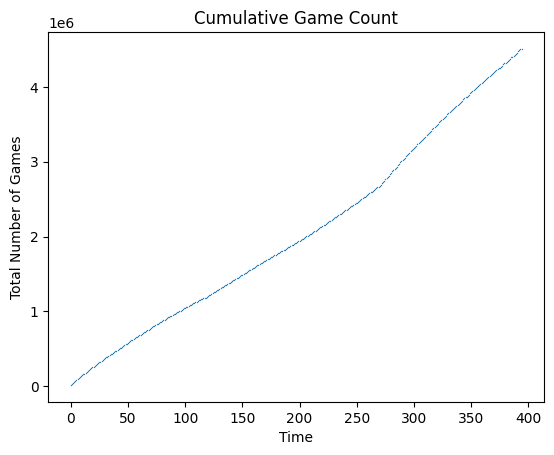

In [5]:
games_played = pd.DataFrame({"time": range(df_456.groupby("time").size().__len__()), "games_played": df_456.groupby("time").size().cumsum().to_list()})
sns.scatterplot(data = games_played, x = "time", y = "games_played", s = 1)

plt.title("Cumulative Game Count")
plt.xlabel("Time")
plt.ylabel("Total Number of Games")

In [6]:
df_456 = df_456.assign(period = np.where(df_456["time"] < 232, 0, 1))

# Group by the 'period' column and count the number of games in each period
period_counts = df_456.groupby("period").size()

# Extract the counts for periods 0 and 1, handling cases where a period might be missing
games_period_0 = period_counts.get(0, 0)
games_period_1 = period_counts.get(1, 0)

# Print the result
print(f"There are {games_period_0} games in period 0, {games_period_1} games in period 1")

There are 2255507 games in period 0, 2254826 games in period 1


In [7]:
min_game_threshold = 50

p0 = df_456.loc[:, ["P0", "P0_MMR", "period"]].rename(columns = {"P0": "PID", "P0_MMR": "MMR"})
p1 = df_456.loc[:, ["P1", "P1_MMR", "period"]].rename(columns = {"P1": "PID", "P1_MMR": "MMR"})
player = pd.concat([p0, p1]).groupby(["PID", "period"]).agg(Mean_MMR = ("MMR", "mean"), Game_Count = ("MMR", "count")).reset_index()

player = player.pivot(index = "PID", columns = "period", values = ["Mean_MMR", "Game_Count"]).reset_index(drop = False)
player.columns = ['{}_{}'.format(*col) if col[1] != '' else '{}'.format(col[0]) for col in player.columns]
player = player[(player["Game_Count_0"] >= min_game_threshold) & (player["Game_Count_1"] >= min_game_threshold)].dropna(axis = 0)

# MMR_Group == 0 if Mean_MMR_0 is below 50%
# MMR_Trend == 0 if MMR_Diff is below 50%
player = player.assign(MMR_Group = np.where(player["Mean_MMR_0"] < player["Mean_MMR_0"].median(), 0, 1),
                       MMR_Diff = player["Mean_MMR_1"] - player["Mean_MMR_0"])
player = player.assign(MMR_Trend = np.where(player["MMR_Diff"] < player["MMR_Diff"].median(), 0 , 1))

print(f"There are {player.shape[0]} unique players in the data set.")
player.head()

There are 7552 unique players in the data set.


,PID,Mean_MMR_0,Mean_MMR_1,Game_Count_0,Game_Count_1,MMR_Group,MMR_Diff,MMR_Trend
3,178,741.404580,716.464072,131.0,334.0,0,-24.940508,0
22,1868,1509.419355,1492.416667,62.0,204.0,1,-17.002688,0
27,2105,963.594203,981.602273,69.0,176.0,0,18.008070,0
90,6967,553.372881,558.200000,59.0,75.0,0,4.827119,0
117,8689,816.810458,848.800000,153.0,65.0,0,31.989542,0


We compare the MMR Difference in MMR_Group 0 and 1. 

,PID,Mean_MMR_0,Mean_MMR_1,Game_Count_0,Game_Count_1,MMR_Diff,MMR_Trend
MMR_Group,,,,,,,
0,9315316.0,856.944589,891.549351,117.0,141.0,34.376215,1.0
1,7855135.5,1132.301082,1175.656139,113.0,155.0,30.201059,0.0


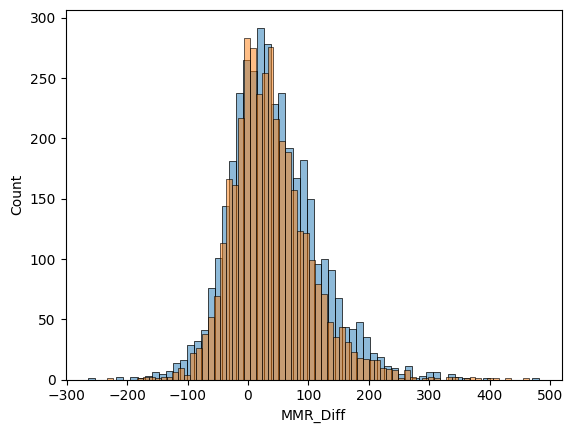

In [8]:
sns.histplot(player[player["MMR_Group"] == 0], x = "MMR_Diff", alpha = 0.5)
sns.histplot(player[player["MMR_Group"] == 1], x = "MMR_Diff", alpha = 0.5)

player.groupby("MMR_Group").median()

Here we define:  
1. the away group to include all players who:  
    AW_L.   had low MMR and gain more MMR than the median   
    AW_H.   had high MMR but lost more MMR than the median  
2. the toward group to include all players who:  
    TW_L.   had low MMR and lost more MMR than the median  
    TW_H.   had high MMR and gained more MMR than the median

In [9]:
player_reduce = player.drop(columns = ["Mean_MMR_1", "Game_Count_0", "Game_Count_1", "MMR_Diff"])

away = player_reduce[(player_reduce["MMR_Group"] == player_reduce["MMR_Trend"])].sort_values(by = "Mean_MMR_0").reset_index(drop = True).reset_index()
toward = player_reduce[(player_reduce["MMR_Group"] == 1 - player_reduce["MMR_Trend"])].sort_values(by = "Mean_MMR_0").reset_index(drop = True).reset_index()

AID = away["PID"].tolist()
TID = toward["PID"].tolist()

aw_gs = away.groupby("MMR_Group").size().tolist()
tw_gs = toward.groupby("MMR_Group").size().tolist()
print(f"In the away group, there are {aw_gs[0]} AW_L player, {aw_gs[1]} AW_H player. \nIn the toward group, there are {tw_gs[0]} TW_L player, {tw_gs[1]} TW_H player.")

In the away group, there are 1833 AW_L player, 1833 AW_H player. 
In the toward group, there are 1943 TW_L player, 1943 TW_H player.


Creating the two sets of edge lists

In [10]:
df_AW = df_456[df_456["P0"].isin(AID) & df_456["P1"].isin(AID)].loc[:, ["P0", "P1", "period"]]
df_AW = (
    pd.merge(df_AW, away, how = "left", left_on = "P0", right_on = "PID")
    .rename(columns = {"index": "P0_ID"})
    .merge(away, "left", left_on = "P1", right_on = "PID")
    .rename(columns = {"index": "P1_ID"})
).filter(regex = "^P[01]|period")

E_AW_0 = df_AW[df_AW["period"] == 0].filter(regex = "_ID$").values.tolist()
E_AW_1 = df_AW[df_AW["period"] == 1].filter(regex = "_ID$").values.tolist()

G_AW_0 = ig.Graph(edges = E_AW_0, directed = False).simplify(multiple=True, loops=False)
G_AW_1 = ig.Graph(edges = E_AW_1, directed = False).simplify(multiple=True, loops=False)

A_AW_0 = torch.Tensor(G_AW_0.get_adjacency().data)
A_AW_1 = torch.Tensor(G_AW_1.get_adjacency().data)

print(f"The median degree of AW_0 is {A_AW_0.sum(dim = 0).median().item()}, there are {A_AW_0.sum()/2} edges in total")
print(f"The median degree of AW_1 is {A_AW_1.sum(dim = 0).median().item()}, there are {A_AW_1.sum()/2} edges in total")

AW_wthn_mask = torch.block_diag(*[torch.ones(n, n) for n in aw_gs])

wthn_degree_0 = (A_AW_0 * AW_wthn_mask).sum(dim = 0).reshape(2, 1833).median(dim = 1)[0].tolist()
btwn_degree_0 = (A_AW_0 * torch.abs(1 - AW_wthn_mask)).sum(dim = 0).median()

wthn_degree_1 = (A_AW_1 * AW_wthn_mask).sum(dim = 0).reshape(2, 1833).median(dim = 1)[0].tolist()
btwn_degree_1 = (A_AW_1 * torch.abs(1 - AW_wthn_mask)).sum(dim = 0).median()

print(f"At t = 0, the within-group median degree is {[round(i, 2) for i in wthn_degree_0]}, and the between-group median degree is {btwn_degree_0/2: .2f}")
print(f"At t = 1, the within-group median degree is {[round(i, 2) for i in wthn_degree_1]}, and the between-group median degree is {btwn_degree_1/2: .2f}")

The median degree of AW_0 is 40.0, there are 92323.0 edges in total
The median degree of AW_1 is 25.0, there are 61901.0 edges in total
At t = 0, the within-group median degree is [31.0, 38.0], and the between-group median degree is  1.00
At t = 1, the within-group median degree is [18.0, 33.0], and the between-group median degree is  0.00


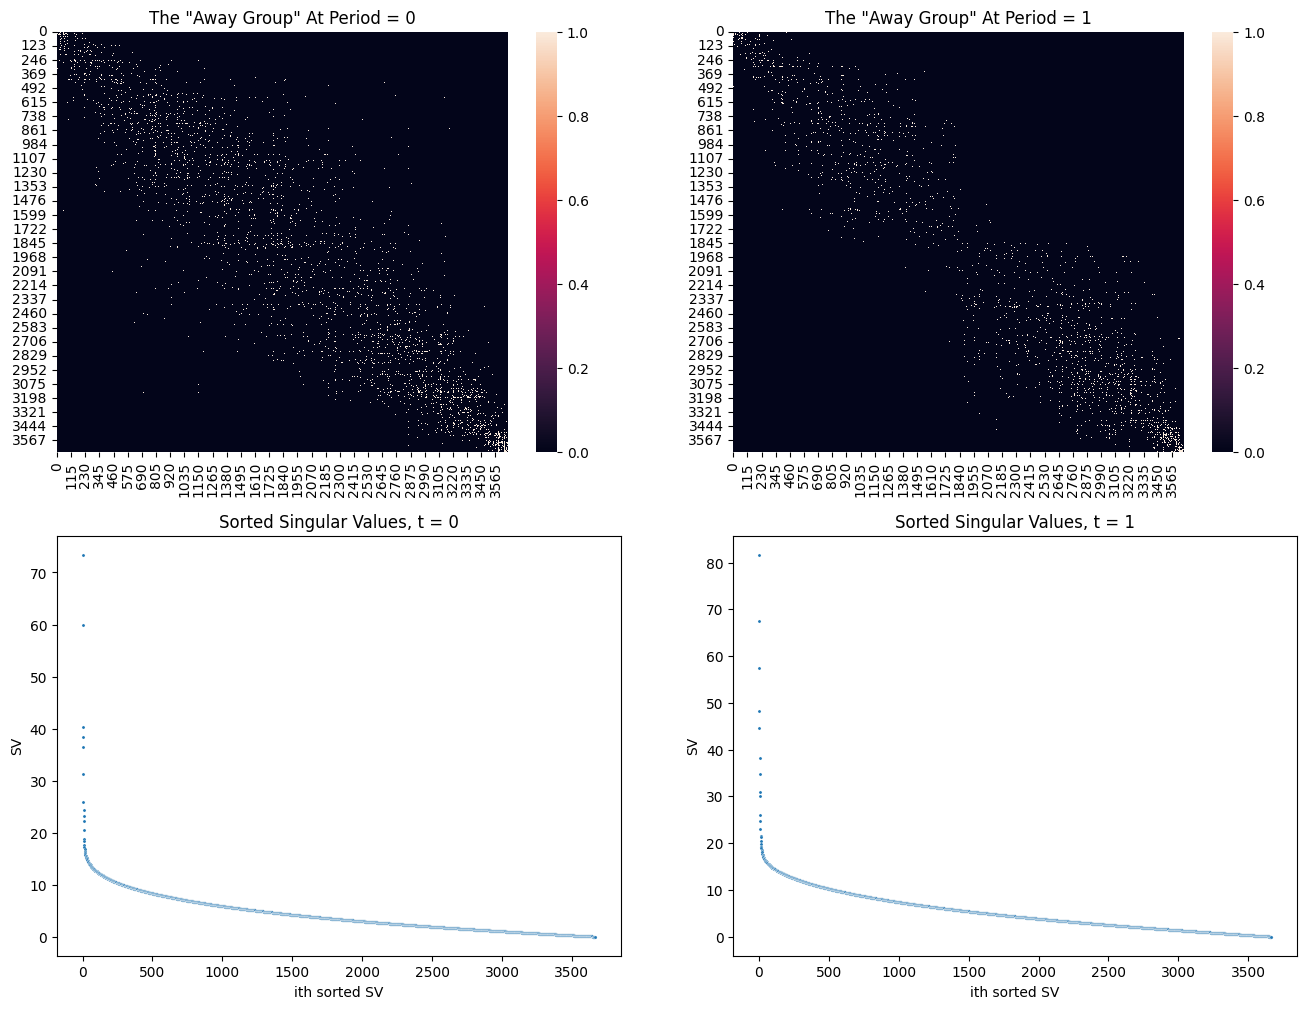

In [11]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot the first heatmap
sns.heatmap(A_AW_0, ax=axes[0, 0])
axes[0, 0].set_title('The "Away Group" At Period = 0')

# Plot the second heatmap
sns.heatmap(A_AW_1, ax=axes[0, 1])
axes[0, 1].set_title('The "Away Group" At Period = 1')

ATW1_svd = torch.svd(A_AW_1)
sns.scatterplot(x = list(range(len(ATW1_svd[1]))), y = ATW1_svd[1], s = 5, ax = axes[1, 0])
# Add title and axis labels
axes[1, 0].set_title('Sorted Singular Values, t = 0')
axes[1, 0].set_xlabel('ith sorted SV')
axes[1, 0].set_ylabel('SV')

ATW0_svd = torch.svd(A_AW_0)
sns.scatterplot(x = list(range(len(ATW0_svd[1]))), y = ATW0_svd[1], s = 5, ax = axes[1, 1])
# Add title and axis labels
axes[1, 1].set_title('Sorted Singular Values, t = 1')
axes[1, 1].set_xlabel('ith sorted SV')
axes[1, 1].set_ylabel('SV')

# Display the plots
plt.show()

In [12]:
df_TW = df_456[df_456["P0"].isin(TID) & df_456["P1"].isin(TID)].loc[:, ["P0", "P1", "period"]]
df_TW = (
    pd.merge(df_TW, toward, how = "left", left_on = "P0", right_on = "PID")
    .rename(columns = {"index": "P0_ID"})
    .merge(toward, "left", left_on = "P1", right_on = "PID")
    .rename(columns = {"index": "P1_ID"})
).filter(regex = "^P[01]|period")

E_TW_0 = df_TW[df_TW["period"] == 0].filter(regex = "_ID$").values.tolist()
E_TW_1 = df_TW[df_TW["period"] == 1].filter(regex = "_ID$").values.tolist()

G_TW_0 = ig.Graph(edges = E_TW_0, directed = False).simplify(multiple=True, loops=False)
G_TW_1 = ig.Graph(edges = E_TW_1, directed = False).simplify(multiple=True, loops=False)

A_TW_0 = torch.Tensor(G_TW_0.get_adjacency().data)
A_TW_1 = torch.Tensor(G_TW_1.get_adjacency().data)

print(f"The median degree of TW_0 is {A_TW_0.sum(dim = 0).median().item()}, there are {A_TW_0.sum()/2} edges in total")
print(f"The median degree of TW_1 is {A_TW_1.sum(dim = 0).median().item()}, there are {A_TW_1.sum()/2} edges in total")

TW_wthn_mask = torch.block_diag(*[torch.ones(n, n) for n in tw_gs])

wthn_degree_0 = (A_TW_0 * TW_wthn_mask).sum(dim = 0).reshape(2, tw_gs[0]).median(dim = 1)[0].tolist()
btwn_degree_0 = (A_TW_0 * torch.abs(1 - TW_wthn_mask)).sum(dim = 0).median()

wthn_degree_1 = (A_TW_1 * TW_wthn_mask).sum(dim = 0).reshape(2, tw_gs[0]).median(dim = 1)[0].tolist()
btwn_degree_1 = (A_TW_1 * torch.abs(1 - TW_wthn_mask)).sum(dim = 0).median()

print(f"At t = 0, the within-group median degree is {[round(i, 2) for i in wthn_degree_0]}, and the between-group median degree is {btwn_degree_0/2: .2f}")
print(f"At t = 1, the within-group median degree is {[round(i, 2) for i in wthn_degree_1]}, and the between-group median degree is {btwn_degree_1/2: .2f}")

The median degree of TW_0 is 40.0, there are 97892.0 edges in total
The median degree of TW_1 is 30.0, there are 76193.0 edges in total
At t = 0, the within-group median degree is [29.0, 43.0], and the between-group median degree is  0.50
At t = 1, the within-group median degree is [19.0, 25.0], and the between-group median degree is  3.00


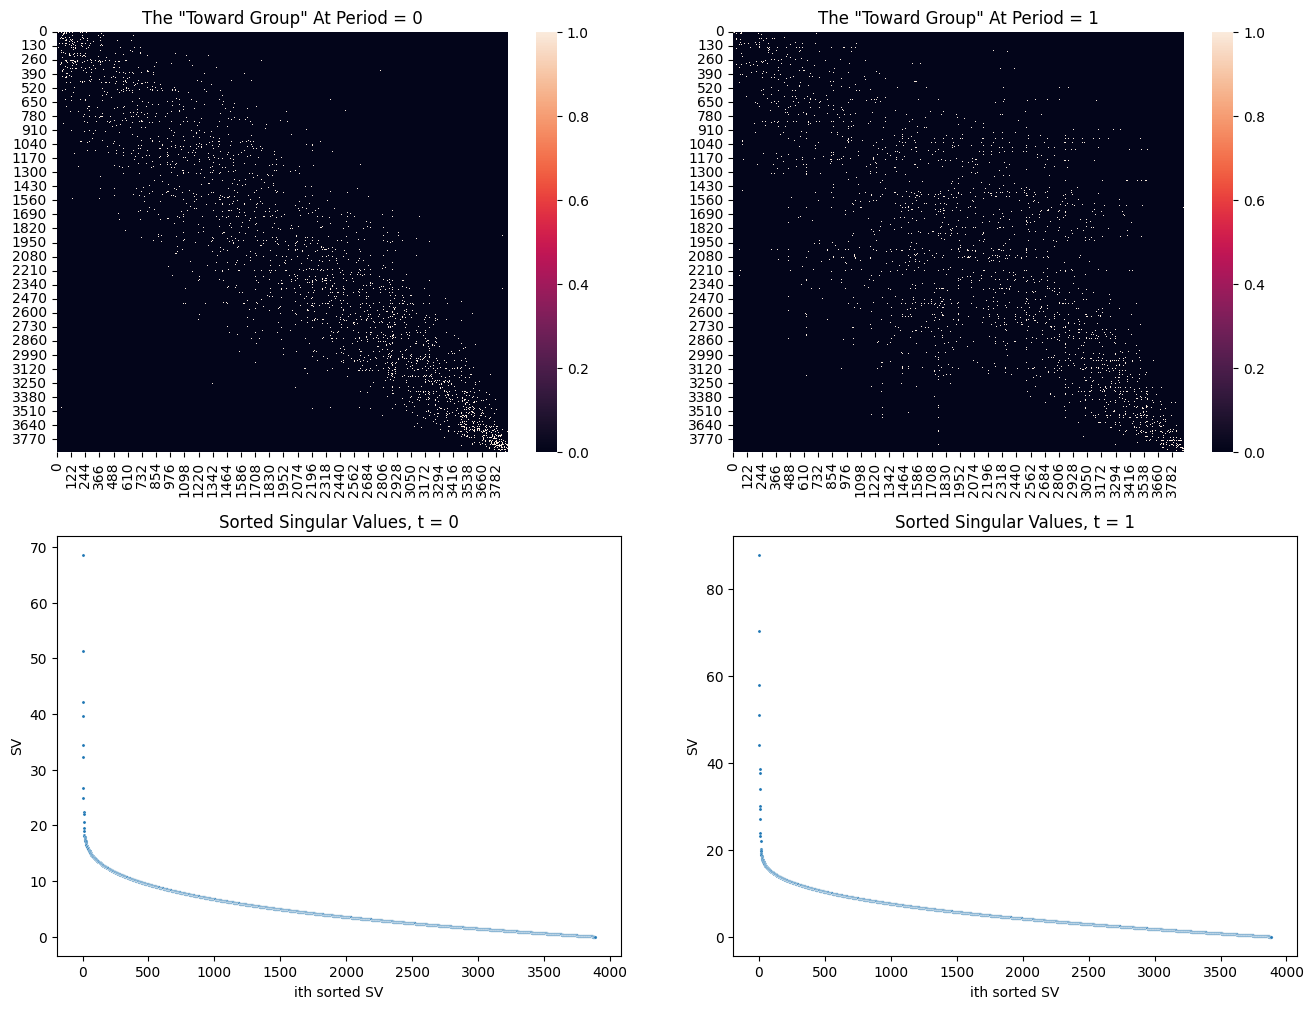

In [13]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot the first heatmap
sns.heatmap(A_TW_0, ax=axes[0, 0])
axes[0, 0].set_title('The "Toward Group" At Period = 0')

# Plot the second heatmap
sns.heatmap(A_TW_1, ax=axes[0, 1])
axes[0, 1].set_title('The "Toward Group" At Period = 1')

ATW1_svd = torch.svd(A_TW_1)
sns.scatterplot(x = list(range(len(ATW1_svd[1]))), y = ATW1_svd[1], s = 5, ax = axes[1, 0])
# Add title and axis labels
axes[1, 0].set_title('Sorted Singular Values, t = 0')
axes[1, 0].set_xlabel('ith sorted SV')
axes[1, 0].set_ylabel('SV')

ATW0_svd = torch.svd(A_TW_0)
sns.scatterplot(x = list(range(len(ATW0_svd[1]))), y = ATW0_svd[1], s = 5, ax = axes[1, 1])
# Add title and axis labels
axes[1, 1].set_title('Sorted Singular Values, t = 1')
axes[1, 1].set_xlabel('ith sorted SV')
axes[1, 1].set_ylabel('SV')

# Display the plots
plt.show()

In [14]:
def embed_tensor_pd(embeding, index_df):
    
    pd_embed = pd.DataFrame(embeding.detach().numpy())
    pd_embed["index"] = pd_embed.index
    pd_embed = pd.merge(pd_embed, index_df, how = "left", on = "index")
    pd_embed = pd_embed.assign(MMR_Group = np.where(pd_embed["MMR_Group"] == 0, "0", "1"))
    
    return(pd_embed)

def gen_X(Y, Z, group_sizes):
    Y = Y.to(device)
    n, p = Z.shape
    
    # Z_s = Z[:, :(p-1)].to(device)
    Z_s = Z.to(device)

    #within-group indicator matrix -- jth element of ith row is 1 IF j and i has the same group membership
    wthin_g = torch.block_diag(*[torch.ones(i, i) for i in group_sizes]).to(device)
    #between-group indicator matrix       
    btwn_g  = (-1)*(wthin_g - 1)        

    Y1 = (Y * wthin_g)
    Y2 = (Y * btwn_g)

    all_ones = torch.ones(n,1).to(device)

    #take row/col sums of within/between group adjacency matrix -- this will be the scaling factor
    S1 = torch.max(all_ones, torch.sum(Y1, 1, True)).repeat(1, p)   
    S2 = torch.max(all_ones, torch.sum(Y2, 1, True)).repeat(1, p)

    A1 = Y1.matmul(Z_s)/S1
    A2 = Y2.matmul(Z_s)/S2

    X = torch.cat((Z_s, A1, A2, all_ones), 1)

    X = X.to("cpu")
    del(Z_s, wthin_g, btwn_g, Y1, Y2, all_ones, S1, S2, A1, A2)
    torch.cuda.empty_cache()

    return(X)

In [15]:
# fig = px.scatter_3d(data_frame = pd_init_TW_0, x = 0, y = 1, z = 2, color = "MMR_Group", 
#                     color_discrete_sequence=["blue", "red"])
# fig.update_traces(marker=dict(size=1))

Here we look at the behavior of the Toward Group.  

In [34]:
p = 5
C = Dir_Reg.fit.gen_constraint(p+1, True)
H = torch.linalg.solve(C.T @ C, C.T)

init_TW_0 = Align.Oracle.ASE(A_TW_0, p)
init_TW_1 = Align.Oracle.ASE(A_TW_1, p)

fit_TW_0 = Align.GD_RDPG(A_TW_0, 50, init_TW_0, smoothing = 100, tol = 1e-1, verbose = False)
prev_lp = fit_TW_0.fitted.clone().detach().to(device)
fit_TW_1 = Align.GD_RDPG(A_TW_1, 30, prev_lp, smoothing = 100, tol = 1e-1, verbose = False)

 3.19% of data is lost in fitting t = 0, 
 3.04% of data is lost in fitting t = 1. 
 There are 3886 data points in total.


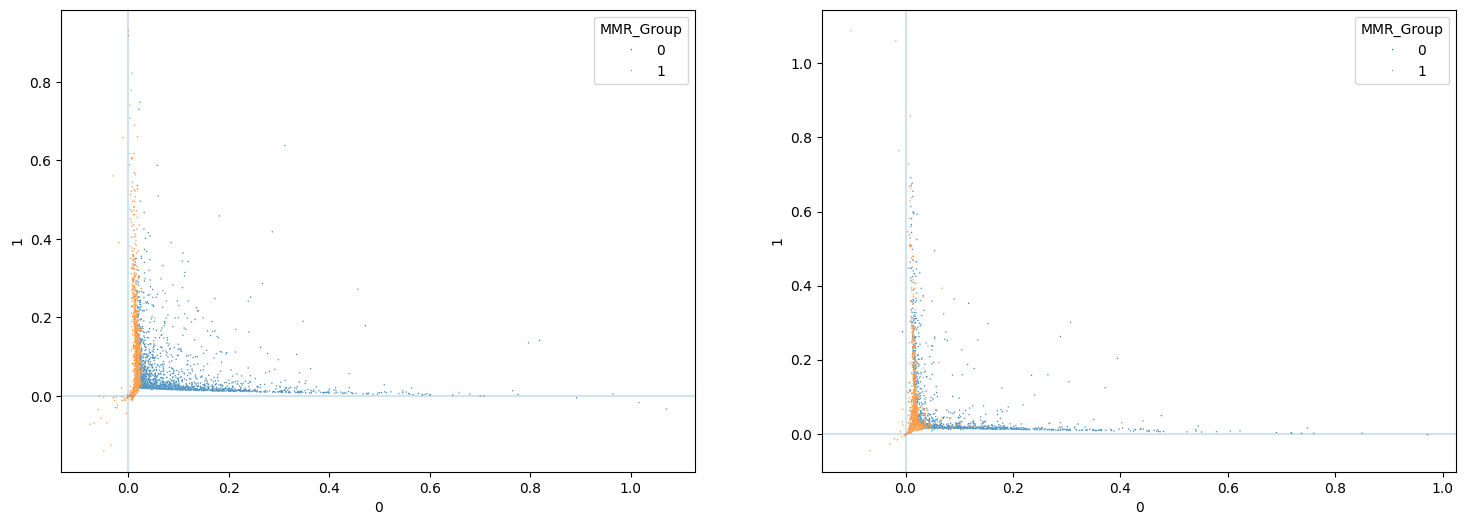

In [36]:
pd_fit_TW_0 = embed_tensor_pd(fit_TW_0.fitted.cpu(), toward)
pd_fit_TW_1 = embed_tensor_pd(fit_TW_1.fitted.cpu(), toward)

dim_0 = 0
dim_1 = 1

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(pd_fit_TW_0, x = dim_0, y = dim_1, s = 1, hue = "MMR_Group", ax = axes[0])
axes[0].axhline(0, alpha = 0.2)
axes[0].axvline(0, alpha = 0.2)
sns.scatterplot(pd_fit_TW_1, x = dim_0, y = dim_1, s = 1, hue = "MMR_Group", ax = axes[1])
axes[1].axhline(0, alpha = 0.2)
axes[1].axvline(0, alpha = 0.2)

print(f"{100*fit_TW_0.loss_data/A_TW_0.shape[0]: .2f}% of data is lost in fitting t = 0, \n{100 * fit_TW_1.loss_data/A_TW_0.shape[0]: .2f}% of data is lost in fitting t = 1. \n There are {A_TW_0.shape[0]} data points in total.")

In [37]:
TW_G_size = pd_fit_TW_0.groupby("MMR_Group").size().tolist()

ZT_0 = fit_TW_0.fitted.cpu().detach()
XT_0 = gen_X(A_TW_0, ZT_0, TW_G_size)

ZT_1 = fit_TW_1.fitted.cpu().detach()
ZT_1 = torch.cat([ZT_1, 1 - ZT_1.sum(dim = 1).reshape(ZT_1.shape[0], 1)], dim = 1)

In [42]:
B_guess = torch.tensor([1.2242, 0.3, 0.8262, 0.0071])
result = DR.fit(XT_0, ZT_1, beta_guess = B_guess, tol = 0.01, max_iter= 50000, verbose = False)
result.Dir_GD_unconstrained()

est = result.est_result["estimate"].cpu()
fisher = result.est_result["fisher_info"].cpu()

est_c = (H @ est.reshape(-1)).detach().tolist()
fisher_c = torch.diag(H @ torch.linalg.solve(fisher, H.T)).detach().tolist()

print(f"\nThe estimate of \u03B2 is {[round(i, 4) for i in est_c]}.")
print(f"the theoretical st.dev is {[round(np.sqrt(i), 4) for i in fisher_c]}.")
print(f"{100*result.est_result['info_lost']: .2f}% of the data (n = {ZT_0.shape[0]}) was lost due to embedding.")
print(f"Gradient ascent took {result.est_result['num_iter']} iterations.")


The estimate of β is [1.2244, 0.2996, 0.8222, 0.0048].
the theoretical st.dev is [0.0393, 0.0613, 0.1637, 0.0688].
 5.20% of the data (n = 3886) was lost due to embedding.
Gradient ascent took 6377 iterations.


In [47]:
result.Dir_NGD_unconstrained()
est = result.NGD_result["estimate"].cpu()
fisher = result.NGD_result["fisher_info"].cpu()

NGD_c = (H @ est.reshape(-1)).detach().tolist()
fisher_c = torch.diag(H @ torch.linalg.solve(fisher, H.T)).detach().tolist()

print(f"\nThe NGD estimate of \u03B2 (initiated at result from Adam) is {[round(i, 4) for i in NGD_c]}.")
print(f"the theoretical st.dev is {[round(np.sqrt(i), 4) for i in fisher_c]}.")
print(f"{100*result.NGD_result['info_lost']: .2f}% of the data (n = {ZT_0.shape[0]}) was lost due to embedding.")
print(f"Gradient ascent took {result.NGD_result['num_iter']} iterations.")


The NGD estimate of β (initiated at result from Adam) is [1.2276, 0.2974, 0.8035, 0.0088].
the theoretical st.dev is [0.0393, 0.0613, 0.1628, 0.0688].
 5.20% of the data (n = 3886) was lost due to embedding.
Gradient ascent took 6 iterations.


Here we look at the behavior of the Away Group.  

In [59]:
p = 5
C = Dir_Reg.fit.gen_constraint(p+1, True)
H = torch.linalg.solve(C.T @ C, C.T)

init_AW_0 = Align.Oracle.ASE(A_AW_0, p)
init_AW_1 = Align.Oracle.ASE(A_AW_1, p)

fit_AW_0 = Align.GD_RDPG(A_AW_0, 50, init_AW_0, smoothing = 100, tol = 1e-1, verbose = False)
prev_lp = fit_AW_0.fitted.clone().detach().to(device)
fit_AW_1 = Align.GD_RDPG(A_AW_1, 30, prev_lp, smoothing = 100, tol = 1e-1, verbose = False)

 2.40% of data is lost in fitting t = 0, 
 2.40% of data is lost in fitting t = 1. 
 There are 3666 data points in total.


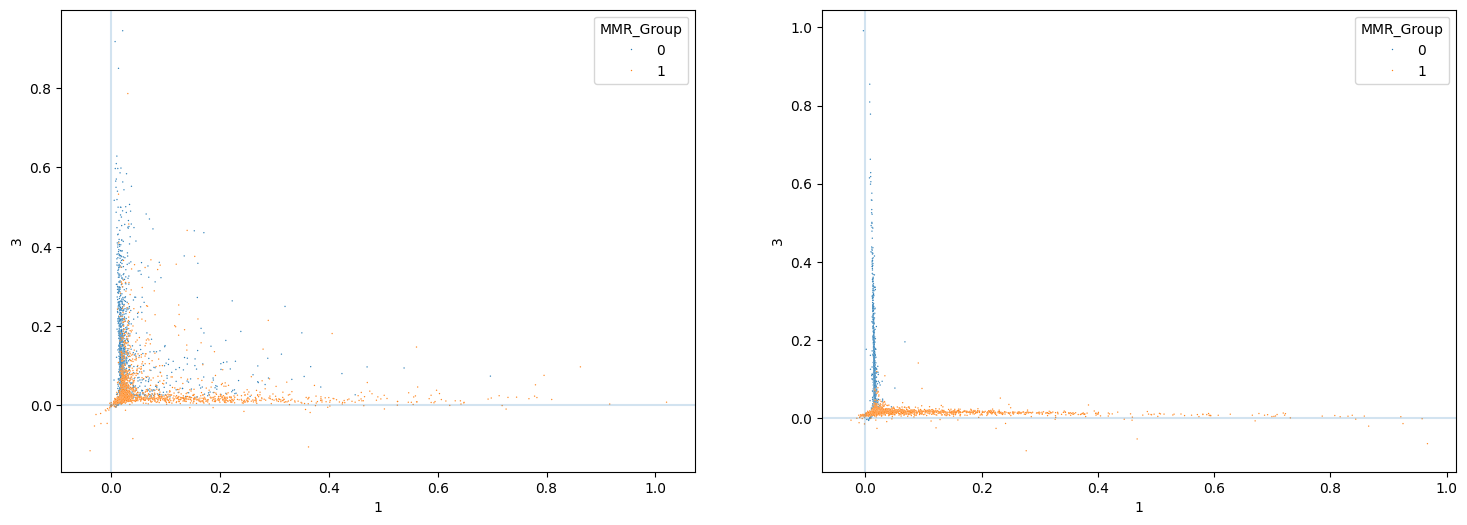

In [60]:
pd_fit_AW_0 = embed_tensor_pd(fit_AW_0.fitted.cpu(), away)
pd_fit_AW_1 = embed_tensor_pd(fit_AW_1.fitted.cpu(), away)

dim_0 = 1
dim_1 = 3

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(pd_fit_AW_0, x = dim_0, y = dim_1, s = 1, hue = "MMR_Group", ax = axes[0])
axes[0].axhline(0, alpha = 0.2)
axes[0].axvline(0, alpha = 0.2)
sns.scatterplot(pd_fit_AW_1, x = dim_0, y = dim_1, s = 1, hue = "MMR_Group", ax = axes[1])
axes[1].axhline(0, alpha = 0.2)
axes[1].axvline(0, alpha = 0.2)

print(f"{100*fit_AW_0.loss_data/A_AW_0.shape[0]: .2f}% of data is lost in fitting t = 0, \n{100 * fit_AW_1.loss_data/A_AW_0.shape[0]: .2f}% of data is lost in fitting t = 1. \n There are {A_AW_0.shape[0]} data points in total.")

In [61]:
AW_G_size = pd_fit_AW_0.groupby("MMR_Group").size().tolist()

ZA_0 = fit_AW_0.fitted.cpu().detach()
XA_0 = gen_X(A_AW_0, ZA_0, AW_G_size)

ZA_1 = fit_AW_1.fitted.cpu().detach()
ZA_1 = torch.cat([ZA_1, 1 - ZA_1.sum(dim = 1).reshape(ZA_1.shape[0], 1)], dim = 1)

In [62]:
B_guess = torch.tensor([1.5827, 1.7414, -0.3395, 1.1938])
result = DR.fit(XA_0, ZA_1, beta_guess = B_guess, tol = 0.1, max_iter = 50000,  verbose = False)
result.Dir_GD_unconstrained()

est = result.est_result["estimate"].cpu()
fisher = result.est_result["fisher_info"].cpu()

est_c = (H @ est.reshape(-1)).detach().tolist()
fisher_c = torch.diag(H @ torch.linalg.solve(fisher, H.T)).detach().tolist()

print(f"\nThe estimate of \u03B2 is {[round(i, 4) for i in est_c]}.")
print(f"the theoretical st.dev is {[round(np.sqrt(i), 4) for i in fisher_c]}.")
print(f"{100* result.est_result['info_lost']: .2f}% of the data (n = {ZA_0.shape[0]}) was lost due to embedding.")
print(f"Gradient ascent took {result.est_result['num_iter']} iterations.")


The estimate of β is [1.6029, 1.6185, -0.4105, 1.1216].
the theoretical st.dev is [0.0357, 0.0594, 0.1247, 0.0854].
 4.31% of the data (n = 3666) was lost due to embedding.
Gradient ascent took 6997 iterations.


Sanity Check

In [50]:
T, n, alpha_0 = 2, 6000, [[1,1,1], [1,1,1], [1,1,1]]
C = Dir_Reg.fit.gen_constraint(3, True)
model_neg_4 = sim.ABC(time = T,
                    nodes = n,
                    beta = [1,1,-4,5],
                    alpha_0 = alpha_0)

Z0, Z1 = model_neg_4.synth_data["lat_pos"]
Y0, Y1 = model_neg_4.synth_data["obs_adj"]

X0 = sim.ABC.gen_X(Y0, Z0, 3)
result = DR.fit(X0, Z1, beta_guess = torch.tensor([ 1.0080,  0.9214, -3.9061,  2.8101]), tol = 1)
result.Dir_GD_unconstrained()
est = result.est_result["estimate"]

print(f"estimate of \u03B2 is {torch.linalg.solve(C.T @ C, C.T) @ est.reshape(-1)}")

estimate of β is tensor([ 0.9986,  0.9654, -4.0441,  3.7142])
